# INFO204 Practical Test 1 (Practice)

## PLEASE NOTE: THE PURPOSE OF THIS PRACTICE TEST IS TO PROVIDE A _ROUGH_ IDEA OF HOW THE TEST WILL BE PRESENTED - WHILE WILL BE OVERLAP IN CONCEPTS, THE ORDER AND MANNER IN WHICH QUESTIONS ARE ASKED MAY DIFFER. ALSO, THE ACTUAL TEST WILL CONTAIN A SMALL NUMBER (2-3) OF EXAM-LIKE SHORT ANSWER QUESTIONS THAT ARE BASED ON LECTURE CONTENT, DETAILS ON HOW TO PREPARE FOR THESE QUESTIONS WILL BE PROVIDED ON BLACKBOARD

Please enter your details below:<br />
***Student Name:***

***Student ID:***

## Guidelines:
- Attempt **all** tasks as best you can.
- Type in your solution code in the cell *right under* each task and run it. Keep the output. 
- If stuck on one task, don't waste your time - there are other tasks you can attempt.
- All work (bar one exercise) has been discussed in labs - please use the previous labs as inspiration to complete this test.

## Precursors

### <span style="color: #ce2227;">Please run the first cell to import relevant libraries and to define the `extract_cv_stats` function that will be used later in the test. This will also declare a repeated 10-fold cross validation generator called `rkf` and a mean squared error scoring function `mse_score` that will be used throughout the test.</span>

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from matplotlib import pyplot as plt

def cleanup_cv_results(cv, model_name='model'):
    import re
    
    cv_results = pd.DataFrame(cv.cv_results_)

    ## there's a few columns returned by GridSearchCV.fit() that we don't need, so let's get rid of them to make things clearer
    unwanted_columns = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'mean_test_score', 'std_test_score', 'rank_test_score']

    ## remove the "param_"  and "param_model__" prefixes from columns
    r = re.compile(f"param_({model_name}__)*")
    cleaned_names = cv_results.drop(columns=unwanted_columns).rename(columns=lambda x: r.sub('', x))

    ## identify all the columns that are not the per-split cross validation scores
    r = re.compile(f"split.+_test_score")
    header_cols = [ c for c in cleaned_names.columns.values if not r.match(c) ]
    
    ## return the long version of the data
    long_data = cleaned_names.melt(id_vars=header_cols, var_name='split', value_name='score')
    long_data['split'] = long_data['split'].replace('split([0-9]+)_test_score', '\\1', regex=True).astype(int)
    return long_data

rkf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1234)

## Data Manipulation

***Note: <span style="color: #ce2227;">In this test, assume the response variable is named `target` and use this as the response (target) in all subsquent questions</span>***

### Q1: load the CSV file <span style="font-family: monospace">regression_features.csv</span> into a pandas data frame called `features`. Then, load the CSV file <span style="font-family: monospace">regression_target.csv</span> into a pandas data frame called `target`. Join these two data frames together using the common column information - name the resulting data frame `all_data`. Display the data frame `all_data`

In [21]:
### REPLACE THIS COMMENT WITH YOUR CODE
features = pd.read_csv('regression_features.csv')
target = pd.read_csv('regression_target.csv')

all_data = features.merge(target, how = 'inner', on = 'instance')
display(all_data)

,instance,feature,value,target
0,1,a,8.986976,20.047446
1,1,b,-0.007598,20.047446
2,1,c,-29.232291,20.047446
3,1,d,-4.018822,20.047446
4,1,e,-73.714993,20.047446
...,...,...,...,...
1524,300,a,30.958732,27.991566
1525,300,b,-0.001346,27.991566
1526,300,c,-12.961023,27.991566
1527,300,d,7.007661,27.991566


### Q2: `all_data` is in long format - convert it to wide format, using the `instance` and `target` columns as index. Once the data frame is in long format, use the [`reset_index`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html) function to restore `instance` and `target` as actual columns. Then, remove the `instance` column from the data frame. Finally, display the data frame

In [20]:
### REPLACE THIS COMMENT WITH YOUR CODE
all_Data = all_data.pivot(index = ['instance', 'target'], columns= 'feature', values = 'value').reset_index()
all_data.drop(columns = 'instance', inplace = True)
display(all_data)

feature,instance,target,a,b,c,d,e,f
0,1,20.047446,8.986976,-0.007598,-29.232291,-4.018822,-73.714993,NaN
1,2,30.125555,25.408926,0.005434,-70.139014,8.381520,96.895231,NaN
2,3,25.256983,19.183764,0.006431,78.585614,2.432709,-90.047302,NaN
3,4,27.599680,-2.745190,-0.004271,-11.835395,-2.036732,-22.924117,NaN
4,5,26.063893,0.833724,-0.004649,43.169487,3.226333,55.930777,NaN
...,...,...,...,...,...,...,...,...
295,296,31.515162,19.590663,0.006242,94.475348,-7.773013,62.922212,-0.960818
296,297,24.688468,13.045841,-0.000857,23.103342,7.269379,28.535237,NaN
297,298,20.999443,12.309355,-0.009963,63.585106,-9.302368,14.694665,NaN
298,299,27.176497,7.200073,-0.000035,-2.369066,-9.784755,-66.979813,NaN


### Q3: Save the edited wide-format data frame to a new CSV file called <span style="font-family: monospace">tidy_regression_data.csv</span>

In [22]:
### REPLACE THIS COMMENT WITH YOUR CODE
all_data.to_csv('tidy_regression_data.csv', index =False)

## Exploratory Data Analysis

### Q4: Read the CSV file <span style="font-family: monospace">regression_data.csv</span> into a data frame called `dataset`. Then, print out descriptive statistics of the data frame

In [25]:
### REPLACE THIS COMMENT WITH YOUR CODE
dataset = pd.read_csv('regression_data.csv')
dataset.describe()
display(dataset)

display(dataset.info())

display(dataset.describe())

display(dataset.corr())

,a,b,c,d,e,f,target
0,8.986976,-0.007598,-29.232291,-4.018822,-73.714993,NaN,20.047446
1,25.408926,0.005434,-70.139014,8.381520,96.895231,NaN,30.125555
2,19.183764,0.006431,78.585614,2.432709,-90.047302,NaN,25.256983
3,-2.745190,-0.004271,-11.835395,-2.036732,-22.924117,NaN,27.599680
4,0.833724,-0.004649,43.169487,3.226333,55.930777,NaN,26.063893
...,...,...,...,...,...,...,...
295,19.590663,0.006242,94.475348,-7.773013,62.922212,-0.960818,31.515162
296,13.045841,-0.000857,23.103342,7.269379,28.535237,NaN,24.688468
297,12.309355,-0.009963,63.585106,-9.302368,14.694665,NaN,20.999443
298,7.200073,-0.000035,-2.369066,-9.784755,-66.979813,NaN,27.176497


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   a       300 non-null    float64
 1   b       300 non-null    float64
 2   c       300 non-null    float64
 3   d       300 non-null    float64
 4   e       300 non-null    float64
 5   f       29 non-null     float64
 6   target  300 non-null    float64
dtypes: float64(7)
memory usage: 16.5 KB


None

,a,b,c,d,e,f,target
count,300.000000,300.000000,300.000000,300.000000,300.000000,29.000000,300.000000
mean,13.088256,-0.000358,2.170911,0.537874,-1.119483,-0.154153,26.486427
std,9.403854,0.005510,60.061307,5.726491,56.272674,0.517493,3.422700
min,-16.848149,-0.009963,-98.968427,-9.959542,-99.587729,-0.992580,17.789558
25%,6.423202,-0.004884,-50.459015,-3.989650,-53.372841,-0.503713,24.177934
50%,13.665496,-0.000605,3.113148,0.910437,-0.476621,-0.079971,26.555541
75%,19.997912,0.003853,53.724575,5.393286,48.480896,0.263232,28.979078
max,34.721925,0.009900,99.521140,9.888281,98.830684,0.858021,36.037462


,a,b,c,d,e,f,target
a,1.000000,0.132222,-0.006134,-0.080402,0.049659,0.192698,0.227416
b,0.132222,1.000000,-0.026679,0.035988,0.054966,0.088544,0.571333
c,-0.006134,-0.026679,1.000000,-0.089828,0.004499,-0.041429,-0.035971
d,-0.080402,0.035988,-0.089828,1.000000,-0.018927,0.303494,0.050612
e,0.049659,0.054966,0.004499,-0.018927,1.000000,0.125724,0.282913
f,0.192698,0.088544,-0.041429,0.303494,0.125724,1.000000,0.157126
target,0.227416,0.571333,-0.035971,0.050612,0.282913,0.157126,1.000000


### Q5: Produce a heatmap of the correlations of the numeric columns in `dataset`, and a pairwise scatter plot of `dataset`

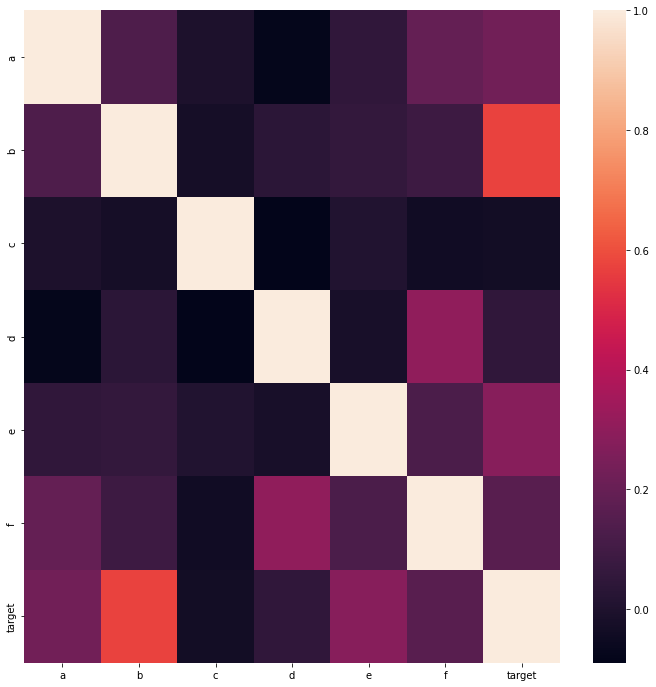

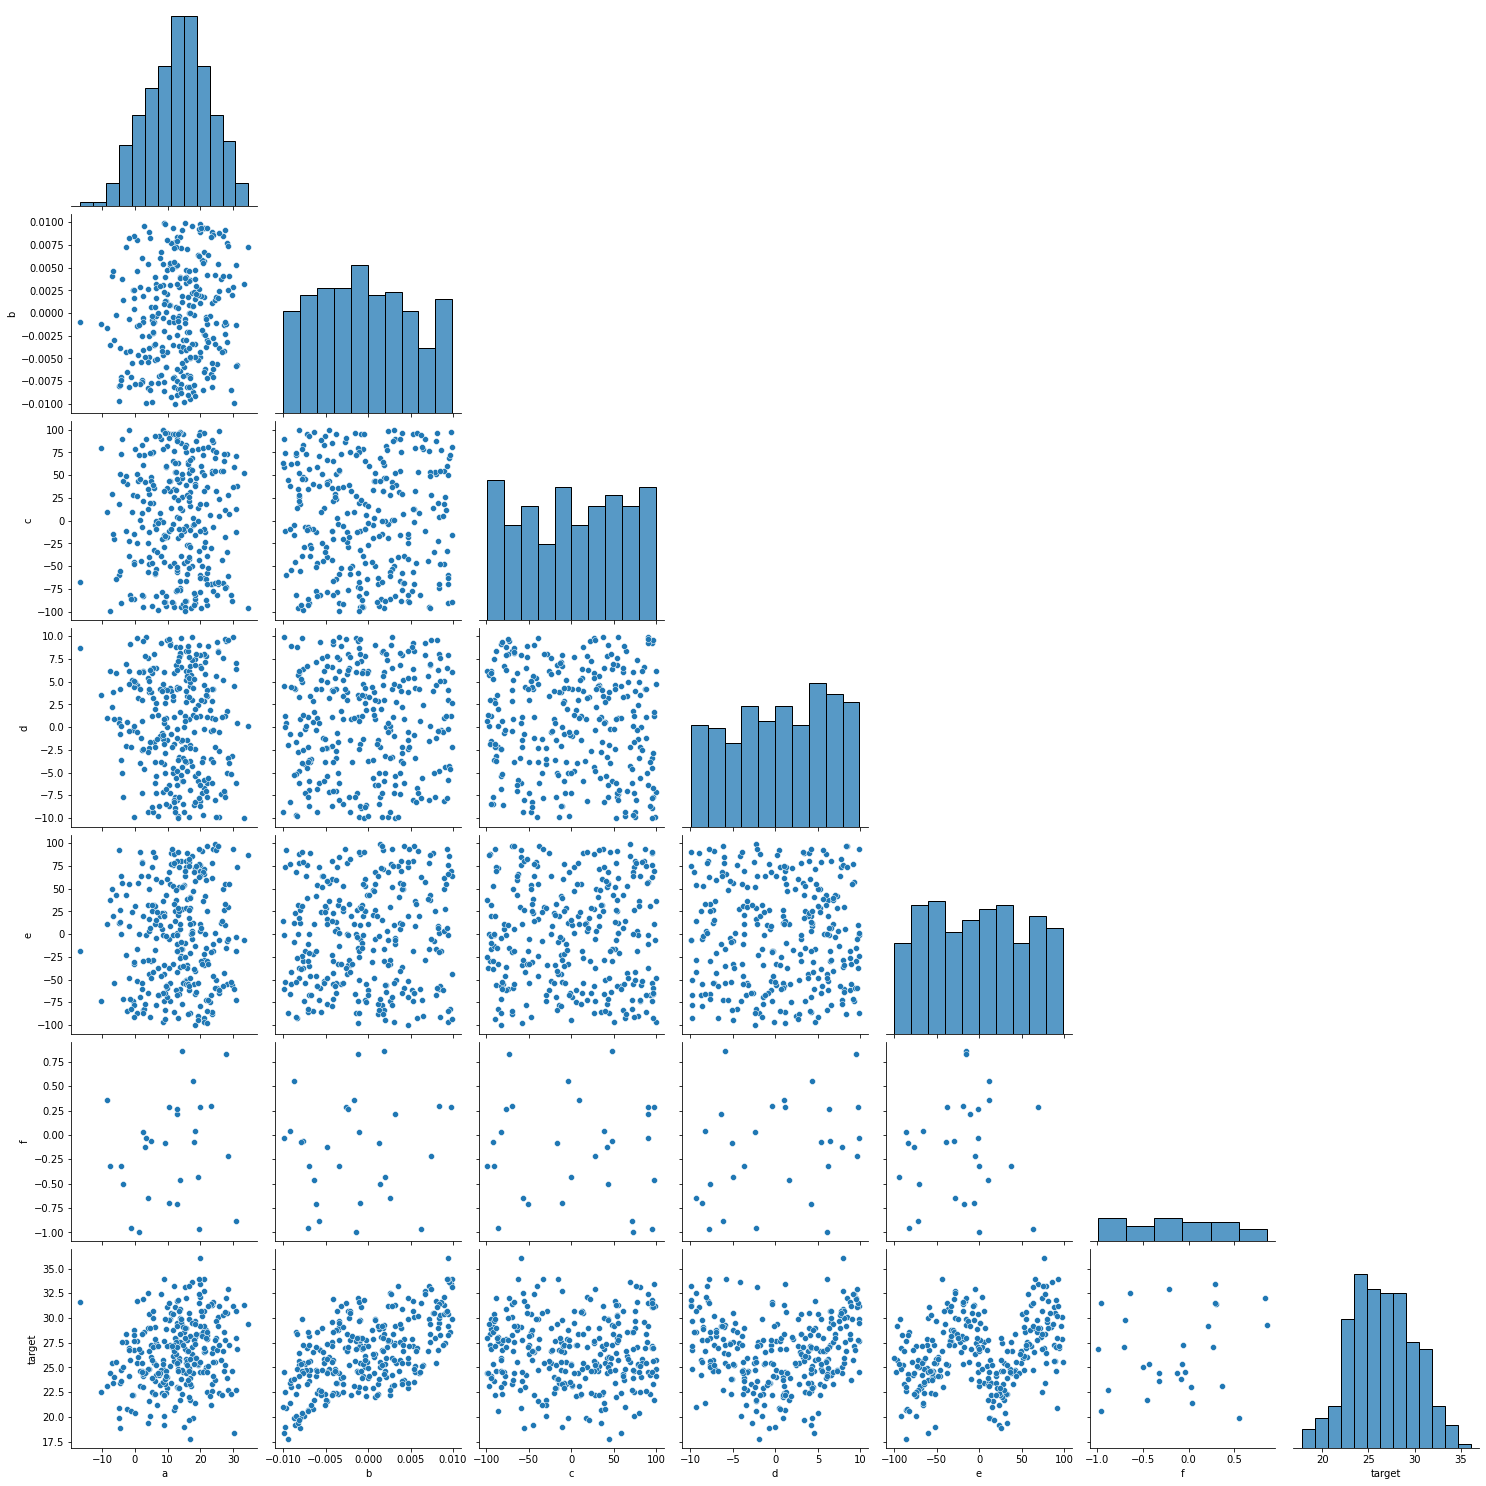

In [34]:
fig = plt.figure(figsize=(12, 12))
sns.heatmap(dataset.corr())
sns.pairplot(dataset, aspect=1, height=3, corner=True);

### Q6: Identify THREE columns in `dataset` for removal and briefly suggest (1-3 sentences total) why these columns can be removed. Then, put the names of the columns into a list called `drop_columns`. Finally, remove these columns from `dataset`

#### _a and c appear to have little to no relationship with the response. While d and e appear to be uncorrelated to the response, they have a clear underlying non-linear relationship to the response (and so a non-linear learner may be able to exploit them). Finally, f has MANY missing values, so rather than remove instances with missing values, we will remove this column_

In [40]:
### REPLACE THIS COMMENT WITH YOUR CODE
dropcolumn = ['a', 'c', 'f']
dataset.drop(columns = dropcolumn, inplace = True)

KeyError: "['a', 'c', 'f'] not found in axis"

### Q7: Extract the features of `dataset` into an array named `X`, and the response into a variable named `t`. Create a list of the feature names, and store the result in a variable named `feature_names`

In [41]:
target = 'target'
X = dataset.drop(columns=target).to_numpy()
t = dataset[target].to_numpy()
feature_names = dataset.drop(columns=target).columns.values


,b,d,e,target
0,-0.007598,-4.018822,-73.714993,20.047446
1,0.005434,8.381520,96.895231,30.125555
2,0.006431,2.432709,-90.047302,25.256983
3,-0.004271,-2.036732,-22.924117,27.599680
4,-0.004649,3.226333,55.930777,26.063893
...,...,...,...,...
295,0.006242,-7.773013,62.922212,31.515162
296,-0.000857,7.269379,28.535237,24.688468
297,-0.009963,-9.302368,14.694665,20.999443
298,-0.000035,-9.784755,-66.979813,27.176497


### Q8: define a machine learning pipeline named `mlpipe`. This pipeline needs two steps: one called `'preprocess'` that is set to `'passthrough'` by default, and another step called `'model'` that defaults to a `DummyRegressor`.

In [43]:
mlpipe = Pipeline([
    ('preprocess', 'passthrough'),
    ('model', DummyRegressor())
])

### Q9: define a suitable hyperparameter tuning grid for the pipeline `mlpipe` such that it uses a decision tree to model the data. The tuning grid should explore the following decision tree hyperparameter `min_samples_split` at the values: 2, 4, 8, 16, 32, 64, 128, and 256.

In [44]:
CART = DecisionTreeRegressor(random_state=0)

CART_param_grid = {
    'preprocess' : [ 'passthrough' ],
    'model' : [ CART ],
    'model__min_samples_split' : [2,4,8,16,32,64,128,256]
}

### Q10: define a suitable hyperparameter tuning grid for the pipeline `mlpipe` such that it uses k-nearest neighbours to model the data. The preprocessing step should explore standardisation (i.e., using `'passthrough'` or a `StandardScaler`). The tuning grid should also explore the k-nearest neighbour hyperparameters:
1. `n_neighbors` at the values: 2, 4, 8, 16, 32, 64, 128, and 256.
2. `weights` at the values 'uniform', 'distance'

Note: we have not discussed the `weights` hyperparameter for kNN in classes - <strong>you do not need to know what this hyperpameter does for kNN, you only need to be able to assess its impact on performance of kNN for the given problem</strong>. The `weights` hyperparameter adjusts the "Weight function used in prediction" (in other words, how the neighbouring instances are combined to form the final prediction). Possible values are:
* 'uniform' : uniform weights. All points in each neighborhood are weighted equally. (this is what you've been using all semester)
* 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.


In [ ]:
### REPLACE THIS COMMENT WITH YOUR CODE
scale = StandardScaler()
knn = KNeighborsRegressor()
knn_tune_grid = {
    'scale' : [ 'passthrough', scale ],
    'model' : [ knn ],
    'model__n_neighbors' : [2,4,8,16,32,64,128,256],
    'model__weights' : [ 'uniform', 'distance' ]

}

### Q11: Perform cross validation on the tuning grids defined in the previous two questions. Extract the best model identified by cross validation and assign it to a variable named `best_model`. Describe the hyperparameters and score of the best model.

In [ ]:
### REPLACE THIS COMMENT WITH YOUR CODE


#### _DESCRIBE THE MODEL PARAMETERS AND SCORE HERE_

### Q12: Use the provided `cleanup_cv_results` to extract a data frame called `cv_stats`. Then use `cv_stats` to create two line plots: one with the x axis exploring the `min_samples_split` hyperparameter of the decision tree, and another with the x axis exploring the `n_neighbors` hyperparameter of kNN. For the kNN plot, use the `hue` semantic to visualise the `'weights'` hyperparameter, and a `style` hyperparameter to visualise the `'preprocess'` hyperparameter.

In [ ]:
### REPLACE THIS COMMENT WITH YOUR CODE

### Q13: declare a new scorer called `mse_score` that uses `mean_squared_error` (in other words, use the scikit-learn function `make_scorer` to make a new scorer based on the `mean_squared_error` loss function). Perform cross validation on linear regression (using `X` and `t` as source data) using `mse_score` as the required scorer and store the result of this in `lm_scores`. Then, perform cross validation on the best model returned in Q11 (using `X` and `t` as source data) using `mse_score` as the required scorer and store the result of this in `best_scores`. 

In [ ]:
### REPLACE THIS COMMENT WITH YOUR CODE

### Q14: Create a data frame, called `results`, that contains two columns: the `best_scores` and `lm_scores` arrays from Q13. Convert this data frame from its wide format into long format, naming the "variable" column `'method'` and the "value" column `'MSE'`. Group this long version of the data frame by `'method'` and aggregate the result such that the resulting data frame presents the mean MSE value for each method.

In [ ]:
### REPLACE THIS COMMENT WITH YOUR CODE

### Q15: Use the `results` data frame to create a boxplot comparing the cross-validated mean-squared error results obtained in Q13. Briefly discuss the relative performance of the methods, and declare which method you would select as your final model for future predictions.

In [ ]:
### REPLACE THIS COMMENT WITH YOUR CODE

#### _WRITE YOUR BRIEF DISCUSSION HERE_

**SELECTED MODEL:** _WRITE YOUR ANSWER HERE_

### Q16: load the CSV file <span style="font-family: monospace">new_regression_data.csv</span> into a pandas data frame. Name the data frame `test`. Use `drop_columns` to remove the extraneous columns (as identified in Q6) in `test`. Extract the features in the `test` data frame into an array called `X_test` and the response into a variable called `t_test`. Use the selected model identified in the previous question to obtain predictions from `X_test` and store the result in `y_test`. Finally, compute and print out the mean squared error and $R^2$ of the predictions in `y_test` relative to `t_test`.

In [ ]:
### REPLACE THIS COMMENT WITH YOUR CODE